## NN Adv Assignment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F

### TensorFlow

# import tensorflow as tf
# from tensorflow import keras

import warnings
warnings.filterwarnings(action='ignore')

### Load Data

In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [3]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train['label'].nunique()

10

In [5]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
X = train.iloc[:, 1:].values
y = train.iloc[:, 0].values

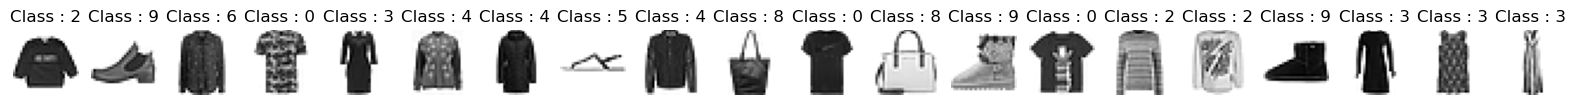

In [7]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
  plt.title(f'Class : {y[idx]}')

In [8]:
X_test = test.iloc[:, 1:].values
y_test = test.iloc[:, 0].values

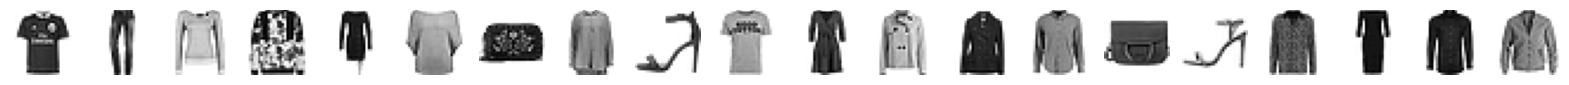

In [9]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

### Train-Test Split

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

## Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

In [11]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cuda


In [12]:
#Batch Size는 조정 가능합니다.
BATCH_SIZE = 256
#Epoch는 고정해주세요.
EPOCHS = 15

In [13]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
  def __init__(self, image, label = None):
    super(DataSet, self).__init__()
    self._image = image
    self._label = label

  def __len__(self):
    return len(self._image)

  def __getitem__(self, idx):
    if self._label is None:
      image = self._image[idx]
      return image

    else:
      image = self._image[idx]
      label = self._label[idx]

      return image, label

In [14]:
train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

In [15]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  correct = 0

  for image, label in train_loader:
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()
      
  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

def pred(model, test_loader):
  model.eval()
  pred_li = []

  with torch.no_grad():
    for image in test_loader:
      image = image.to(DEVICE)
      output = model(image)
      pred_li.append(output.cpu().numpy().argmax(axis=1))

  return np.concatenate(pred_li)

## 직접 Network를 설계하고, 성능을 시험해보자.

### 참고: https://wikidocs.net/63618

In [18]:
class MyNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer = nn.Sequential(nn.Linear(1 * 28 * 28, 1024),
                                   nn.LayerNorm(1024),
                                   nn.ReLU(),
                                   nn.Dropout(0.5),
                                   nn.Linear(1024, 1024),
                                   nn.LayerNorm(1024),
                                   nn.ReLU(),
                                   nn.Dropout(0.5),
                                   nn.Linear(1024, 10),
                                   nn.ReLU()
                                   )
        
    def forward(self, x):
        #여기에 Forward 함수 삽입: __init__에서 추가한 Layer에 순전파시킴
        #Ex. x = self.layer1(x)
        x = x.view(-1, 1 * 28 * 28)
        x = self.layer(x)

        return x
    
model = MyNet().to(DEVICE)
#적절한 optimizer를 선택: torch.optim의 적절한 Optimizer를 사용
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2)
#적절한 Loss function을 선택: nn 모듈의 Function을 사용
criterion = nn.CrossEntropyLoss()

[EPOCH: 1], 	Train Loss: 0.7827, 	Train Accuracy: 73.14 %, 	Val Loss: 0.4582, 	Val Accuracy: 83.57 % 

[EPOCH: 2], 	Train Loss: 0.4834, 	Train Accuracy: 82.84 %, 	Val Loss: 0.4022, 	Val Accuracy: 85.65 % 

[EPOCH: 3], 	Train Loss: 0.4358, 	Train Accuracy: 84.51 %, 	Val Loss: 0.4212, 	Val Accuracy: 84.60 % 

[EPOCH: 4], 	Train Loss: 0.4100, 	Train Accuracy: 85.30 %, 	Val Loss: 0.3680, 	Val Accuracy: 86.68 % 

[EPOCH: 5], 	Train Loss: 0.3890, 	Train Accuracy: 86.13 %, 	Val Loss: 0.3768, 	Val Accuracy: 86.22 % 

[EPOCH: 6], 	Train Loss: 0.3792, 	Train Accuracy: 86.30 %, 	Val Loss: 0.3584, 	Val Accuracy: 86.92 % 

[EPOCH: 7], 	Train Loss: 0.3666, 	Train Accuracy: 86.82 %, 	Val Loss: 0.3441, 	Val Accuracy: 87.18 % 

[EPOCH: 8], 	Train Loss: 0.3579, 	Train Accuracy: 87.13 %, 	Val Loss: 0.3434, 	Val Accuracy: 87.37 % 

[EPOCH: 9], 	Train Loss: 0.3520, 	Train Accuracy: 87.35 %, 	Val Loss: 0.3366, 	Val Accuracy: 87.62 % 

[EPOCH: 10], 	Train Loss: 0.3408, 	Train Accuracy: 87.65 %, 	Val Loss: 0.

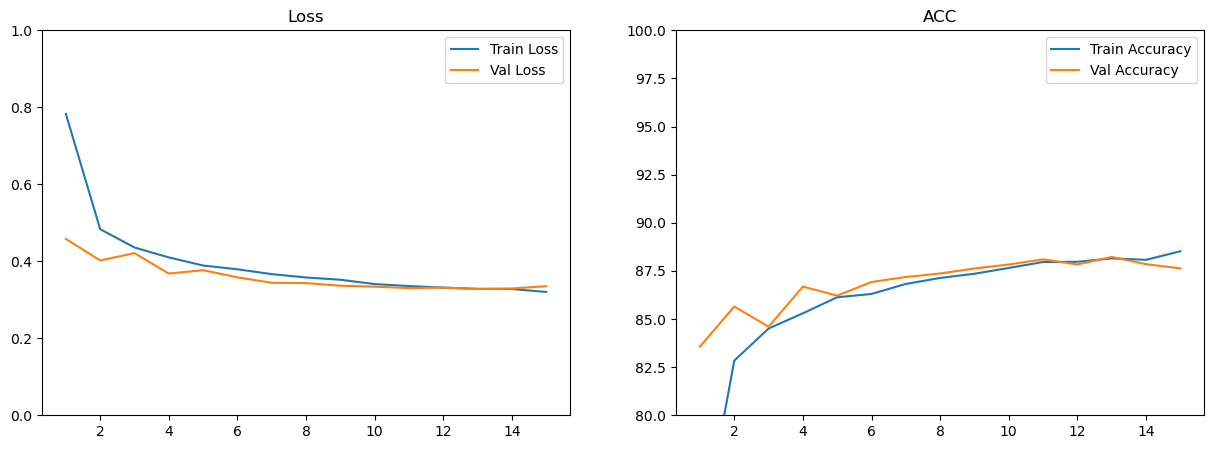

In [19]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

## 결론을 작성해주세요:

In [ ]:
'''
모델은 기본적인 Multi-Layer Perceptron을 사용하였으며, 각 Linear 계층 사이에 정규화와 Dropout을 적용하였다.
배치의 영향을 덜 받으면서 모델의 각 레이어를 정규화 시키기 위해 Layer Normalization을 진행하였으며, 이후 0.5의 확률로 perceptron을 학습에서 제외하여,
모델의 일반화 성능을 높였다.

이후 실험에서 배치를 128, 256, 512의 크기로 해본 결과 256의 배치사이즈가 가장 평가 성능이 잘 나왔으며, 이는 학습이 진행됨에 따라 256개의 이미지를 한번에 볼떄,
각각의 이미지의 패턴과 종합적인 이미지들의 패턴을 잘 고려하며, 학습이 진행됨을 알 수 있다. 이를 통헤 배치가 너무 크거나 작다면 데이터 각각 또는 전체 데이터의 패턴을
익힐 수 없기 때문에 모델의 학습 진행이 어렵다는 것을 알 수 있다.
'''